# Text Analytics mini-Project: Synthetic Biology

Don MacMillen

%%html
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Here is a little background on the topic of [synthetic biology](https://en.wikipedia.org/wiki/Synthetic_biology)

If you want to run this notebook, you will need two data files.  One is synthetic_biology.txt and the other is stopwords.txt and you may need to fiddle with file paths to get them to read correctly.

First, let's do all of our imports.  Note that to run a specific cell, all the cells before it must have run recently and have valid contents.  When in doubt, choose the "Run All Above" menu item in the Cell menu.  If things are really hosed, choose "Restart" from the Kernel menu and then "Run All" from the cell menu.  This will regenerate the entire notebook.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import re
import seaborn as sns
import json
import os
import os.path
import collections
import nltk
from wordcloud import WordCloud
import itertools as it
import networkx as nx
import operator

## 1.  Parsing and Data Ingestion

First, let's just verify that the synthetic_biology.txt file has the same format as what was presented in class. That is, filled with the PubMed records (more on that later)

In [6]:
END_LINE = 76
SOURCE_FILE = 'data/synthetic_biology.txt'

with open(SOURCE_FILE, 'r') as f:      
    for n, line in enumerate(f):
        if n < END_LINE:
            print(line.rstrip())
        else:
            break


PMID- 26409776
OWN - NLM
STAT- Publisher
DA  - 20150927
LR  - 20150928
IS  - 1879-3096 (Electronic)
IS  - 0167-7799 (Linking)
VI  - 33
IP  - 10
DP  - 2015 Oct
TI  - Engineering Biosynthesis Mechanisms for Diversifying Polyhydroxyalkanoates.
PG  - 565-574
LID - S0167-7799(15)00159-6 [pii]
LID - 10.1016/j.tibtech.2015.07.007 [doi]
AB  - Polyhydroxyalkanoates (PHA) are a family of diverse biopolyesters synthesized by
      bacteria. PHA diversity, as reflected by its monomers, homopolymers, random and
      block copolymers, as well as functional polymers, can now be generated by
      engineering the three basic synthesis pathways including the acetoacetyl-CoA
      pathway, in situ fatty acid synthesis, and/or beta-oxidation cycles, as well as
      PHA synthase specificity. It is now possible to tailor the PHA structures via
      genome editing or process engineering. The increasing PHA diversity and maturing
      PHA production technology should lead to more focused research into t

Now let's see just how many records there are in the file.  No need for Python here, a simple command line in bash will do the trick. (Notice we need the minus sign so we do not match spurious 'PMID' subtrings in the file)

In [7]:
!grep PMID- Data/synth/synthetic_biology.txt | wc

grep: Data/synth/synthetic_biology.txt: No such file or directory
      0       0       0


So there are 4167 articles in the database.

Now parse the entire file into the corpus and print a single record of the corpus for a visual check. **Note that there is a rather bad logic bug in the original Lab 2 notebook code.  It actually uses an incorrect PMID as the key of the record inserted into the corpus.**  We can see the following code is correct by printing out a random key and the PMID field of the record associated with that key.  They must match.  We might as well check the entire corpus, which we do at the end.

In [8]:
base_nm, _ = os.path.splitext(os.path.basename(SOURCE_FILE))

# Don't confuse with course download of word counts by article.
CORPUS_JSON = ''.join(('data/dbm_full_', base_nm, '_JSON.txt'))
END_OF_RECORD = 'SO  '
UNIQUE_ID = 'PMID'
    
    
def parse_file(f):
    corpus = {}
    for line in f:
        line = line.rstrip()
        tag = line[0:4]
        content = line[6:]

        # Start of new record.  We depend on this field being at the start
        # of a new record.
        if tag == UNIQUE_ID:
            record = {}
            article_id = content    
            corpus[article_id] = record       
        
        # Handle line continuation.  Note that multiple fields with the same
        # tag will concatenate as well.
        if tag == "    ":
            tag = lasttag
            
        lasttag = tag            
        short_tag = tag.rstrip()

        if len(content) > 0:
            if short_tag in record:
                # Concat the line continuation here
                record[short_tag] = "; ".join((record[short_tag], content))
            else:
                record[short_tag] = content
                
    return corpus
    
    
with open(SOURCE_FILE, 'r') as f:      
    corpus = parse_file(f)

# No real need to write this file
#with open(CORPUS_JSON, 'w') as f:
#    json.dump(corpus, f, indent=4)  # yes, it takes more space, but helps debugging

# Sometimes you just want a single key
def get_random_key(d):
    return d.keys().__iter__().__next__()

rkey = get_random_key(corpus)
print('\nThese need to be the same: {}  {}\n'.format(rkey, corpus[rkey][UNIQUE_ID]))
print(corpus[rkey])

# Try putting this code into the Lab 2 notebook into the end of the codeblock that
# follows "Objective 2. Parsing the File" and you will see the issue. (you will need
# a lower case unique_id though)
errors = 0
missing = 0
for key, record in corpus.items():
    if UNIQUE_ID not in corpus[key]:
        missing += 1
    elif key != corpus[key][UNIQUE_ID]:
        errors += 1

print("\n{} missing PMID fields. {} keys are mismatched".format(missing, errors))


These need to be the same: 21946161  21946161

{'GR': 'R00 GM081450/GM/NIGMS NIH HHS/United States; R00 GM081450-03/GM/NIGMS NIH HHS/United States; R00 GM081450-04/GM/NIGMS NIH HHS/United States; R00GM081450/GM/NIGMS NIH HHS/United States', 'RN': '0 (Multienzyme Complexes)', 'PT': "Journal Article; Research Support, N.I.H., Extramural; Research Support, Non-U.S. Gov't; Research Support, U.S. Gov't, Non-P.H.S.; Review", 'MH': 'Cell-Free System/*enzymology; Multienzyme Complexes/*chemistry/*genetics/*metabolism; Synthetic Biology/*methods', 'IP': '3', 'FAU': 'Hodgman, C Eric; Jewett, Michael C', 'LA': 'eng', 'PHST': '2011/05/09 [received]; 2011/08/19 [revised]; 2011/09/09 [accepted]; 2011/09/18 [aheadofprint]', 'JT': 'Metabolic engineering', 'AB': "Cell-free synthetic biology is emerging as a powerful approach aimed to; understand, harness, and expand the capabilities of natural biological systems; without using intact cells. Cell-free systems bypass cell walls and remove; genetic regul

Well, now that we know there is an error in the class provided code, there is a high chance that the class provided extracted summaries are also incorrect.  We will have to regenerate them.  First we will do the word counts of the title plus the abstract

In [9]:
# create the word count dictionary. major key is article id, values are the word
# count "Counter" dicts.
counter_dict = {}

# Counts of all words in titles and abstracts across all articles
all_words = collections.Counter()

stemmer = nltk.PorterStemmer()

# Will need the stopwords. Format must be one word per line
stopwords =[]
with open('data/stopwords.txt', 'r') as f:      
    for line in f:
        stopwords.append(line.rstrip())

        
def get_words(wrds):
    '''
    get_words:  remove punctuation and split into individual words
    
    Expanded puncuation and substitute to a space to make certain 
    we don't merge on removing punctuation.  We then need to filter out the
    null strings. We could filter stop words here if we didn't want to count them.
    '''
    depunct = re.sub('[";,\.\(\)\\\]', ' ', wrds).lower()
    words = [w for w in depunct.split(" ") if w != '']    
    return words


def add_words(wrds, art_id):
    global counter_dict, all_words
    content = collections.Counter()
    stopwordcount = 0

    for word in get_words(wrds):
        if word in stopwords:
            # if its a stopword count it 
            stopwordcount += 1
        else:
            # if its a content word, stem it and count it
            stem = stemmer.stem(word)
            content[stem] += 1
            
    # add all the stopwords under a single count
    content['allstopwords'] = stopwordcount
    all_words += content
    counter_dict[art_id] = content
    
# Crawl through the corpus adding articles and the word counts
for article_id, article in corpus.items(): 
    cont = article['TI'] if 'TI' in article else ''
    abst = article['AB'] if 'AB' in article else ''
    if cont or abst:
        txt = ' '.join((cont, abst))
        add_words(txt, article_id)
    


In [11]:
# Now save them so we can eyeball
#WORDCOUNT_JSON = ''.join(('data/dbm_wordcount_', base_nm, '_JSON.txt'))
#with open(WORDCOUNT_JSON, 'w') as f:
#    json.dump(counter_dict, f, indent=4)  # yes, it takes more space, but helps debugging

Now we will reproduce the (article, [countries]) and the (article, year) relationships except that we will put them both into the same table.  No table joins needed.  **However** I am definitely going low budget on the country extraction from the address field of the record.  This approach is definitely different from what is presented in the course. There, we are reduced to using regular expressions ("... now you have **two** problems"). 

We side step that here by creating a canonical list of country names and make it into a set.  We then take all the words in the address field and make it into a set as well.  Then we do set intersection to find all the countries in the address field and return that as a list.

This would work perfectly **if** countries were only ever mentioned by their canonical names.  Of course that doesn't happen in real life.  So here we run all the words of the address field through a hand tuned filter that replaces 'clue' names with canonical country names and then do the set intersection.

So we traded fiddling around with regular expressions with fiddling around with remappings.  Tastes vary.  Take your pick.

Just FYI, I got the list of countries as a cvs from [here](http://www.davidmottershead.com/articles/excel-csv-countries/)  (Thanks David!) Then I either dropped completely, or dropped all but one, of the names of multi-word countries and then lower cased them as well.

In [12]:
# If we find these words in the address field, we know the 'canonical' country
# Should be expanded.  This is pretty much custom tweaking...
remap = {'oxford': 'uk', 'ca': 'usa', 'california': 'usa', 'massachusetts': 'usa',
         'rockville': 'usa', 'venter': 'usa', 'kingdom': 'uk'}

# The 'canonical' names of countries. Notice only one word countries are supported
world_countries = set([
    'afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'argentina',
    'armenia', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain',
    'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin',
    'bhutan', 'bolivia', 'botswana', 'brazil', 'brunei', 'bulgaria',
    'burkina faso', 'burundi', 'cabo verde', 'cambodia', 'cameroon',
    'canada', 'chad', 'chile', 'china', 'colombia', 'comoros', 'congo',
    'costa rica', 'ivoire', 'croatia', 'cuba', 'cyprus', 'czech',
    'congo', 'denmark', 'djibouti', 'dominica', 'dominican', 'ecuador',
    'egypt', 'salvador', 'eritrea', 'estonia', 'ethiopia', 'fiji',
    'finland', 'france', 'gabon', 'gambia', 'georgia', 'germany', 'ghana',
    'greece', 'grenada', 'guatemala', 'guinea', 'guyana', 'haiti',
    'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran',
    'iraq', 'ireland', 'israel', 'italy', 'jamaica', 'japan', 'jordan',
    'kazakhstan', 'kenya', 'kiribati', 'kuwait', 'kyrgyzstan', 'laos',
    'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein',
    'lithuania', 'luxembourg', 'macedonia', 'madagascar', 'malawi',
    'malaysia', 'maldives', 'mali', 'malta', 'marshall islands',
    'mauritania', 'mauritius', 'mexico', 'micronesia', 'monaco',
    'mongolia', 'montenegro', 'morocco', 'mozambique', 'myanmar',
    'namibia', 'nauru', 'nepal', 'netherlands', 'zealand',
    'nicaragua', 'niger', 'nigeria', 'norway', 'oman', 'pakistan',
    'palau', 'panama', 'papua', 'paraguay', 'peru', 'philippines',
    'poland', 'portugal', 'qatar', 'korea', 'moldova', 'romania',
    'russia', 'rwanda', 'saint lucia', 'samoa', 'arabia', 'senegal',
    'serbia', 'seychelles', 'sierra', 'singapore', 'slovakia', 'slovenia',
    'solomon', 'somalia', 'spain', 'lanka', 'sudan', 'suriname',
    'swaziland', 'sweden', 'switzerland', 'syria', 'tajikistan',
    'thailand', 'togo', 'tonga', 'tunisia', 'turkey', 'turkmenistan',
    'tuvalu', 'uganda', 'ukraine', 'uk', 'usa', 'uruguay', 'uzbekistan',
    'vanuatu', 'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe'])
                       
                                           
def get_year(txt):
    # definitely low-budget
    return txt[0:4]

def get_countries(txt):
    potentials = set([remap[w] if w in remap else w for w in get_words(txt)])
    countries = list(world_countries.intersection(potentials))
    if len(countries) == 0:
        countries = ["unknown"]
    return countries

date_country = {}
for k, article in corpus.items():
    year = get_year(article['DP']) if 'DP' in article else "unknown"
    countries = get_countries(article['AD']) if 'AD' in article else ["unknown"]
    date_country[k] = [year, countries]

num_unknown = 0
for i, (k, v) in enumerate(date_country.items()):
    if v[1][0] == 'unknown':
        num_unknown += 1
    if i < 10:
        print(k, " ", v)
    
print("\nNumber of articles with unknown countries {} out of {} articles".format(num_unknown, len(date_country)))

21946161   ['2012', ['usa']]
24905856   ['2015', ['denmark']]
22676891   ['2012', ['switzerland']]
24783503   ['2014', ['unknown']]
25512487   ['2014', ['china']]
17269665   ['2007', ['usa']]
24584250   ['2014', ['switzerland']]
19399641   ['2008', ['japan']]
22526790   ['2012', ['netherlands']]
24856730   ['2015', ['denmark']]

Number of articles with unknown countries 586 out of 4167 articles


Well, 586 articles out of 4167 without any country info does not sound good.  Let's look deeper.  We can't do the same shell script trick as we did with 'PMID' because there are multiple 'AD' fields per record in the raw data.  However, they are all concatenated together by the parsing function, so now we can just count them in the corpus.

In [13]:
num_no_addr = 0
for k, rec in corpus.items():
    if 'AD' not in rec:
        num_no_addr += 1
        
print("{} records do not have the address ['AD'] field".format(num_no_addr))

292 records do not have the address ['AD'] field


OK, so we should only have 292 records with unknown countries, not 586.  If I have time, I will come back and tweak the remap dictionary and world_counties set to try and get the 294 'escapees' (and other missing ones from non empty lists too).


We will save a pretty printed json file for further debugging.  It helps a lot.

In [14]:
# Now save them so we can eyeball
#DATECOUNTRY_JSON = ''.join(('data/dbm_datecountry_', base_nm, '_JSON.txt'))
#with open(DATECOUNTRY_JSON, 'w') as f:
#    json.dump(date_country, f, indent=4)  # yes, it takes more space, but helps debugging

So now we have pretty much recovered from bad data.  Let's move onto the next section.

## Reporting

Let's see what we can learn by ordinary techniques.  First we will just replicate from Lab 4 the top 20 cited institutions and the top 20 cited authors.

In [15]:
journal_counter = collections.Counter()

for article_id, article in corpus.items():
    if 'SO' in article:
        cite = article['SO']
        cite_part = cite.split('. ')
        journal = cite_part[0]
        journal_counter[journal] += 1

journ_list = journal_counter.most_common(20)      
print("The top twenty journals in this set are:")
for pair in journ_list:
    print(pair[0], pair[1])

The top twenty journals in this set are:
ACS Synth Biol 261
PLoS One 164
Nucleic Acids Res 131
Curr Opin Biotechnol 114
Proc Natl Acad Sci U S A 107
Nature 90
Methods Mol Biol 90
Biotechnol J 68
Syst Synth Biol 66
Metab Eng 60
Science 58
Curr Opin Chem Biol 53
Trends Biotechnol 50
Methods Enzymol 48
Nat Biotechnol 44
Appl Microbiol Biotechnol 43
J Biotechnol 43
Biotechnol Bioeng 39
Mol Biosyst 39
Sci Rep 38


Everything goes better with plotting...

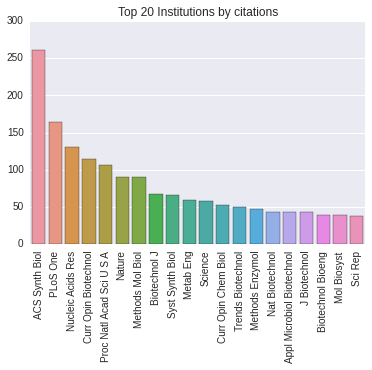

In [16]:
%matplotlib inline

jnames = [j[0] for j in journ_list]
jfreq  = [j[1] for j in journ_list]

sns.barplot(x=jnames, y=jfreq)
plt.xticks(rotation=90)
plt.title('Top 20 Institutions by citations')
plt.show()

Now let's look at the top authors.

In [17]:
author_counter = collections.Counter()
for article_id, article in corpus.items():
    if 'AU' in article:
        author_field = article['AU']
        author_list = author_field.split('; ')
        for author in author_list:
            author_counter[author] += 1
            
auth_list = author_counter.most_common(20)      
print("The top twenty authors in this set are:")
for pair in auth_list:
    print(pair[0],pair[1])

The top twenty authors in this set are:
Marcotte EM 58
Fussenegger M 57
Ellington AD 53
Jiang W 53
Wang J 48
Keasling JD 46
Collins JJ 44
Yang S 44
de Lorenzo V 42
Zhang Y 36
Wang Y 34
Yang Y 34
Silver PA 34
Zhao H 33
Li Y 32
Wang X 30
Weber W 30
Weiss R 29
Lu TK 28
Qin Z 27


And the bar chart looks like:

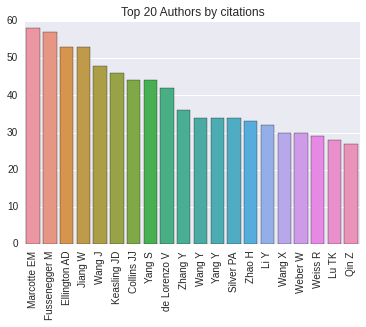

In [18]:
anames = [nm[0] for nm in auth_list]
afreq  = [nm[1] for nm in auth_list]

sns.barplot(x=anames, y=afreq)
plt.xticks(rotation=90)
plt.title('Top 20 Authors by citations')
plt.show()

There an interesting difference in these two plots.  It looks like the citations by institution are falling off with an inverse power law.  This is not too surprising.  Many rank orderings show this behavior.  (See [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law))  What is somewhat surprising is the almost linear fall off of citations for the top 20 authors.  I don't know what conclusions can be drawn from that, but it is interesting and might warrant further investigation.

But the important point here is that we would likely have missed that difference if we only looked at the list of names and frequencies and not plotted them.

Now let's take a look at the word counts by article.  As in the class Lab, we will use pandas for that.

In [19]:
wcDF = pd.DataFrame.from_dict(counter_dict, orient='index')
wcDF = wcDF.fillna(0)
wcDF.head()

,remov,develop,biosynthet,circuit,remain,emerg,synthet,mean,inspir,offer,...,polg,asthet,molecule-induc,fv,ubiquibodi,hsc70-interact,monobodi,scfv,162,methods/princip
11969076,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12520282,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14510412,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14715986,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14715987,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we have many more columns (words) than in the course Lab.  This is probably due to an abundance of biological and chemical names that are present in these papers about synthetic biology.

The shape attribute of a dataframe will give us the number of rows and the number of columns.

In [20]:
wcDF.shape

(4167, 25641)

If we sum all the columns, then we will get the word counts across all documents (never mind that we already created that counter).  We can then order by frequency and plot as a bar chart.  We would expect to see a repeat of a Zipf's Law behavior here too

In [21]:
word_sum = wcDF.sum(axis='index')
print(word_sum.head(10))

remov          119
develop       1947
biosynthet     354
circuit       1219
remain         272
emerg          494
synthet       6207
mean           146
inspir          73
offer          236
dtype: float64


We sort in place and look at the top 20 again

In [22]:
word_sum.sort(ascending=False)
word_sum.head(20)

allstopwords    286497
biolog            6252
synthet           6207
gene              4444
system            3591
protein           3458
cell              3360
engin             3322
design            2737
product           2528
express           2493
function          2281
genet             1949
metabol           1948
develop           1947
model             1865
pathway           1748
dna               1736
network           1631
approach          1584
dtype: float64

Let's get rid of that pesky 'allstopwords' entry and then plot the top 20 words across the entire corpus

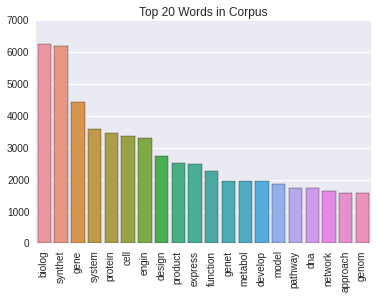

In [23]:
del word_sum['allstopwords']
sns.barplot(x=word_sum.index[:20], y=word_sum.values[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Words in Corpus')
plt.show()

If you work hard, you might convince yourself that this is an inverse square law too (but maybe not).

Let's look briefly at the articles by year and by country. First we look at how the number of papers published has grown over time.

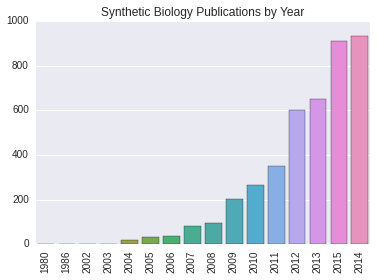

In [24]:
date_count = collections.Counter()
country_count = collections.Counter()
for k, v in date_country.items():
    date_count[v[0]] += 1
    for country in v[1]:
        country_count[country] += 1
        
dS = pd.Series(date_count)
dS.sort()
sns.barplot(x=dS.index, y=dS.values)
plt.xticks(rotation=90)
plt.title('Synthetic Biology Publications by Year')
plt.show()

It is not surprising that it looks like an exponential growth curve.  But has the curve saturated?  It looks like it might have.  The 2015 results will be interesting to see here.

Now for the publications by country:

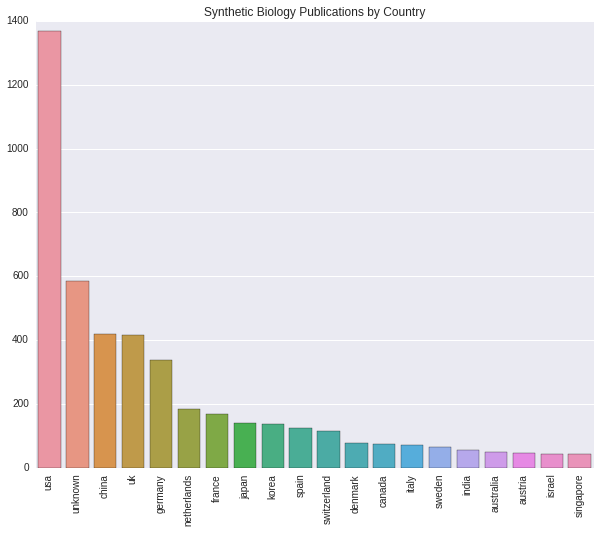

In [25]:
cS = pd.Series(country_count)
cS.sort(ascending=False)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.barplot(x=cS.index[:20], y=cS.values[:20])
plt.xticks(rotation=90)
plt.title('Synthetic Biology Publications by Country')
plt.show()

Now this, once again, looks like an inverse power law.

In the article record, there can be multiple 'OT' (other term) fields that give some indication of the technologies used.  There is also a field named "MH" (MeSH term, or Medical Subject Headings), which lists a MedPub standardized vocabulary of medical subjects.  Let's take a look at the most frequent ones.

BTW, a description of the PubMed record definition would have been very useful to have up front.  I finally found what I was looking for [here](https://www.nlm.nih.gov/bsd/mms/medlineelements.html).  You might find it useful if you want to mine this database further.

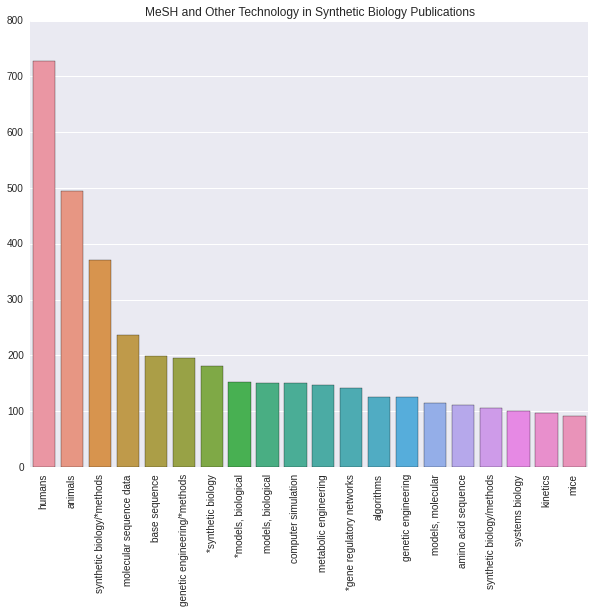

In [26]:
num_techs = collections.Counter()
techs_by_article = collections.defaultdict(list)

for k, v in corpus.items():
    if 'OT' in v:
        tech_list = [x.lower() for x in v['OT'].split('; ')]
        techs_by_article[k].extend(tech_list)
        for tech in tech_list:
            num_techs[tech] += 1
    if 'MH' in v:
        med_list = [x.lower() for x in v['MH'].split('; ')]
        techs_by_article[k].extend(med_list)
        for med in med_list:
            num_techs[med] += 1
            
tS = pd.Series(num_techs)
tS.sort(ascending=False)
del tS['synthetic biology']  # this one would easily dominate, so we remove it.
sns.barplot(x=tS.index[:20], y=tS.values[:20])
plt.xticks(rotation=90)
plt.title('MeSH and Other Technology in Synthetic Biology Publications')
plt.show()

Hey! humans are number one and beat animals. That's cool. These results would give us some directions in which to search if we wanted to broaden the scope of the study of synthetic biology.  But enough of the stuff, now it is time for something different. 

## Analysis

In [27]:
doc_word = pd.DataFrame.from_dict(counter_dict, orient='index')

# remove the 'allstopwords' column
del doc_word['allstopwords']

# fill in nans
doc_word.fillna(0, inplace=True)

# lda requires ints
doc_word = doc_word.astype(int)
doc_word.head()

,remov,develop,biosynthet,circuit,remain,emerg,synthet,mean,inspir,offer,...,polg,asthet,molecule-induc,fv,ubiquibodi,hsc70-interact,monobodi,scfv,162,methods/princip
11969076,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12520282,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14510412,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14715986,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14715987,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
import lda
n_topics = 20
model = lda.LDA(n_topics=n_topics, n_iter=1000, random_state=1137)
%time model = model.fit(doc_word.values)  # returns the model instance itself

CPU times: user 2min 11s, sys: 718 ms, total: 2min 12s
Wall time: 2min 12s


(4167, 20)


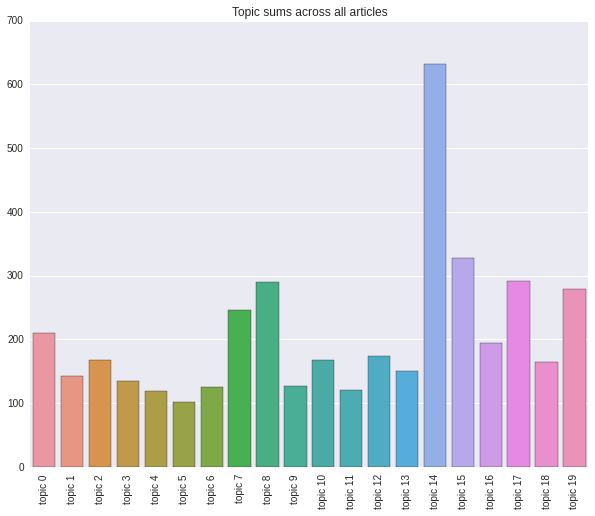

In [29]:
print(model.doc_topic_.shape)
column_sum = np.sum(model.doc_topic_, axis=0)
sns.barplot(x=['topic {}'.format(i) for i in range(20)], y=column_sum)
plt.xticks(rotation=90)
plt.title('Topic sums across all articles')
plt.show()

One of the things about the LDA solution is that the topic numbers can change from solve to solve. We can't just look at the above graph and pick say, topic_11, and expect that one to be the biggest weight across the corpus if we repeated run LDA.

We will look at some of the top topics, but before we dig deeper there, let's do the heat map dance:

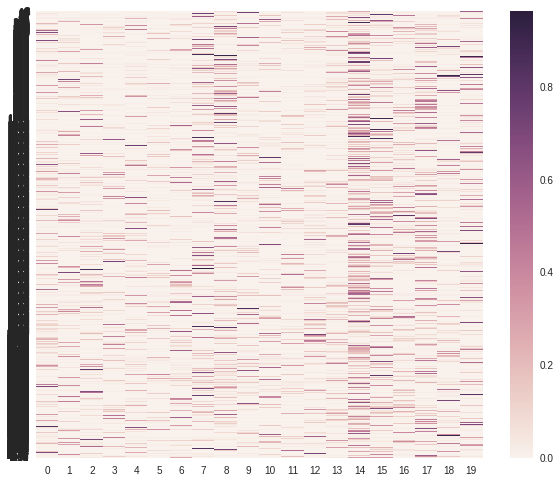

In [30]:
sns.heatmap(model.doc_topic_)
plt.show()

This doesn't really do much for me except to corroborate the bar chart on the weigth of the largest topic, so let's look more there.


Largest topic: 14


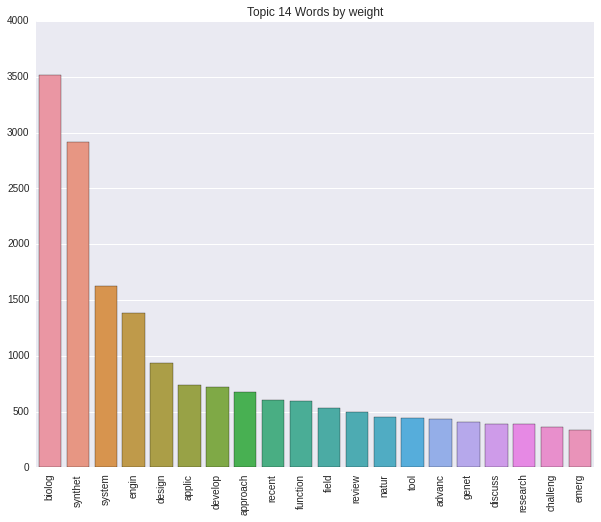

In [31]:
n_topics = 20
print()
topics = []
for i in range(n_topics):
    topS = pd.Series(index=doc_word.columns, data=model.nzw_[i, :])
    topS.sort(ascending=False)
    topics.append(topS)

def plot_topic(n):
    global topics
    sns.barplot(x=topics[n].index[:20], y=topics[n].values[:20])
    plt.xticks(rotation=90)
    plt.title('Topic {} Words by weight'.format(n))
    plt.show()
    
sorted_idx = column_sum.argsort()[-1::-1]
print("Largest topic: {}".format(sorted_idx[0]))
plot_topic(sorted_idx[0])

Interesting, but since I am not versed in synthetic biology, it is hard to put a label on this topic.  Let's look at another one to compare

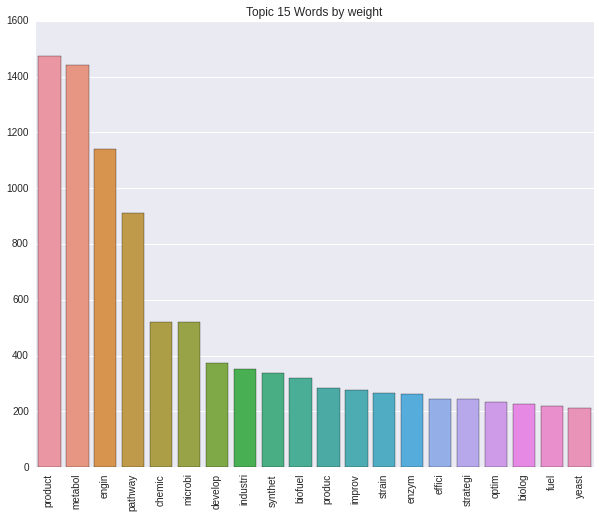

In [32]:
plot_topic(sorted_idx[1])

These are still hard to label, but you might say that largest topic is more general, which would explain its higher weight, and that second largest topic looks to be about potential commercial uses of synthetic biology with words like "product, develop, industri, compound, biofuel, strategi". (Note the stemmed words here)

So topic labelling is hard.  Humans still have to do it, it seems.  But to make topic modeling really useful we will need automatic labeling of topics where the labels actually make sense to us.

Another interesting property to look at is to see if these twenty topics are correlated. We can do that by plotting the correlation matrix.  This will be an n_topic by n_topic matrix (here 20 by 20) where both the columns and the rows are labelled with the topic names.  The main diagonal will contain a topic's correlation with itself, which is always 1.  It two topic are completely anti-correlated, the correlation coefficient is -1.  And, of course, the correlation matrix will be symmetric about the main diagonal.

First we compute the correlation matrix, then use seaborn's heatmap function to plot it.

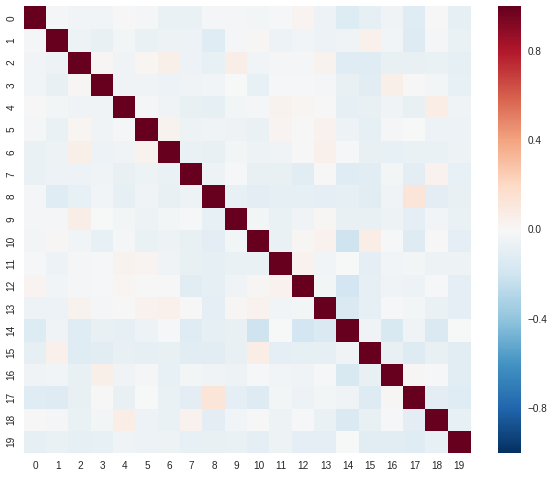

In [33]:
corr = np.corrcoef(model.doc_topic_.T)
sns.heatmap(corr)

So that is very interesting. None of the top 20 topics are strongly correlated with another on.  If we actually had training data on this corpus, we wouldn't have to worry much about the ML optimizer being bother by redundant variables.

So let's do our last parlor trick with topics, and that is word clouds and we will look at the word clouds for the top 2 topics.

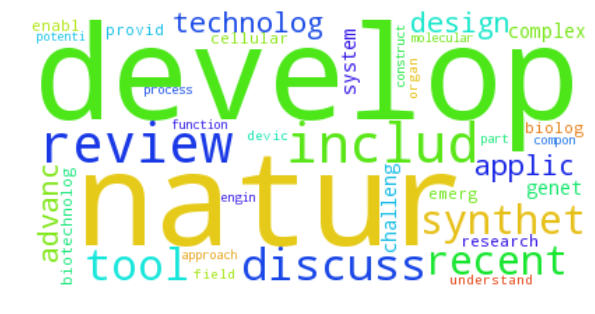

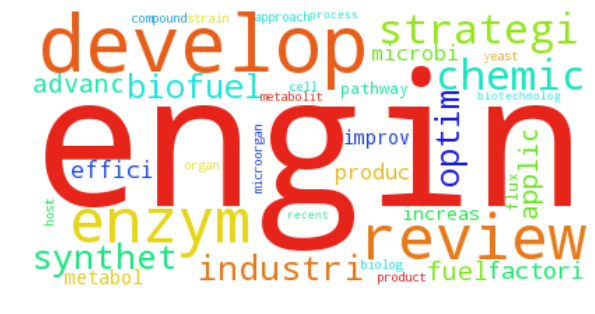

In [34]:
n_top_words = 36
wordcloudobj = WordCloud(background_color='white')

for topic in sorted_idx[:2]:
    word_cloud_string =' '.join(topics[topic].index[:n_top_words])
    wordcloud = wordcloudobj.generate(word_cloud_string)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Changing topics (haha), so now, if we want to do any of the network analysis shown in Lab 7, we need the article_id -> [institution list] to move forward.

If we go the definition of the PubMed records at the website I mentioned earlier, we read the following:

    Affiliation (AD)

    The affiliation of the authors, corporate authors and investigators appear in this     repeating field.  Until 2014, only the affiliation of the first author was included.  The data included in this field and control of the data has changed over time, as follows...
    
Ooops.  I wonder how the data for the class was generated?  Just how good is the data showing collaboration between institutions?  Does it only reflect the recent collaborations?

OK, so we will not worry too much about historical accuracy.  So we will again go low budget on parsing the corpus for affiliations.  But it will be slightly different this time.  Again, we will have a canoncial list, this time of Universities.  But correctly identifying Universities will need more than a single word (or token), so we will remap the whole 'AD' string using regular expressions (OK, so I've got two problems now, I admit it, but we are not doing anything fancy with regexps) to get the canonical name in the string, then break apart into tokens.

Again, all the tweaking will be in the uni_remap dictionary.  A first pass is here, but could be made much, much better.  Note that we don't have remappings for everything, so we will depend on some of the 'raw' words to do the university recognition for us.

Finally, I have increased the size of set of Universities that we will consider.  I took the ones from the class data and then arbitrarily added some others, so it is somewhat dodgy calling this set the 'top_30'

In [35]:
uni_remap = {
    'Chinese Academy of Sciences':                'chineseacadsci',
    'University of Washington':                   'washington',
    'Washington University':                      'washU',
    'University of California, Berkeley':         'berkeley',
    'University of California San Francisco':     'ucsf',
    'University of California at San Francisco':  'ucsf',
    'University of California Los Angeles':       'ucla',
    'Georgia Institute of Technology':            'georgiatech',
    'Massachusetts Institute of Technology':      'mit',
    'University College London':                  'ucl',
    'University of Michigan':                     'umichigan',
    'University of Illinois':                     'uillinois',
    'National Institutes of Health':              'nih-usa'
     }   

top_30 = set(['northeastern', 
               'russianacadsci',
               'chineseacadsci'
               'csic',            # Spanish Institute
               'georgiatech', 
               'singapore',
               'cambridge',
               'duke',
               'caltech',
               'oxford', 
               'uillinois', 
               'mit', 
               'ucla', 
               'harvard', 
               'cnr', 
               'ucl',
               'ucsf',
               'ucsd',
               'rice', 
               'arizona', 
               'northwestern', 
               'manchester',
               'stanford', 
               'umichigan', 
               'cnrs',           # French, but more than one
               'berkeley', 
               'purdue', 
               'nanyang',
               'washu',
               'washington',
               'wisconsin',
               'nih-usa'])

def unis_from_address(addr):
    addr = re.sub(';', ' ', addr).lower()       # get rid of ';' we added earlier
    for k, v in uni_remap.items():
        trgt = re.sub('\s', '\s+', k).lower()   # match names with variable spacing
        addr = re.sub(trgt, v, addr)
    
    potentials = set(get_words(addr))
    universities = list(top_30.intersection(potentials))
    if len(universities) == 0:
        universities = ['None']
    return universities

collab = {}
for article_id, record in corpus.items():
    if 'AD' in record:
        collab[article_id] = unis_from_address(record['AD'])

# The list with mulitple institutions is not that long, so uncomment to look at it
#for k, v in collab.items():
#    if len(v) > 1:
#        print(v)


Now we create the network graph from the recipe in Lab 7

In [36]:
N = nx.Graph()

for key, collab_list in collab.items():
    N.add_nodes_from(collab_list)
    l = list(it.combinations(collab_list, 2))
    if len(l) > 0:
        for e in l:
            a = e[0]
            b = e[1]
            if N.has_edge(a, b):
                N[a][b]['weight'] += 1
            else:
                N.add_edge(a, b, weight=1)

And now some network plots

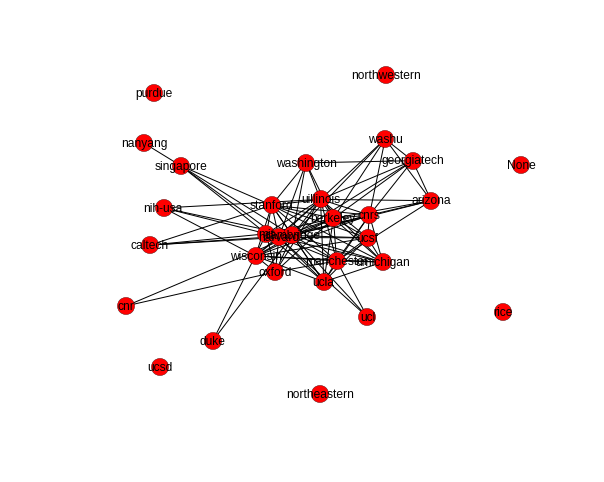

In [37]:
# do some layouts
pos1 = nx.fruchterman_reingold_layout(N)

# set the labels, draw the graph
nx.draw_networkx_labels(N,pos1)
nx.draw(N,pos1)

Now we see just how scarce the data is here.  But, not to cry over it too long, we will just carry on.

First we will remove all the unconnected nodes are replot.

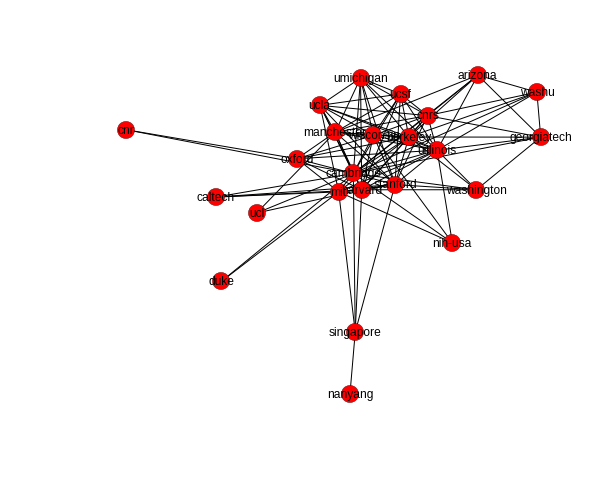

In [38]:
N.remove_node('None')
N.remove_node('purdue')
N.remove_node('northwestern')
N.remove_node('ucsd')
N.remove_node('rice')
N.remove_node('northeastern')

# regenerate the layout
pos1 = nx.fruchterman_reingold_layout(N)

# set the labels, draw the graph
nx.draw_networkx_labels(N,pos1)
nx.draw(N,pos1)

Now for the network distance measures.

In [39]:
import operator

cc = nx.eigenvector_centrality(N)
bc = nx.betweenness_centrality(N)
nx.set_node_attributes(N, 'betweenness', bc)
nx.set_node_attributes(N, 'centrality', cc)

sorted_cc = list(sorted(cc.items(), key=operator.itemgetter(1)))
print("These are the most centrally located nodes, ranked from greatest to smallest.")
print()
rank_eigen = sorted_cc[-1::-1]
for item in rank_eigen:
    print(item)

These are the most centrally located nodes, ranked from greatest to smallest.

('cambridge', 0.6795268029693947)
('mit', 0.6484647137744071)
('harvard', 0.32722546798924546)
('oxford', 0.06922806404533798)
('berkeley', 0.0447697872062136)
('uillinois', 0.026222302534465093)
('stanford', 0.026062165563147232)
('manchester', 0.024610050892976593)
('cnrs', 0.01970799563972615)
('ucla', 0.01631927182943857)
('washington', 0.014351299672046458)
('singapore', 0.01329591497030684)
('wisconsin', 0.012921200473052959)
('ucl', 0.011294182819015081)
('caltech', 0.010941216072646996)
('ucsf', 0.010627624363744419)
('nih-usa', 0.008896877076950326)
('duke', 0.00864214571284041)
('umichigan', 0.008022464931999623)
('arizona', 0.005367588076662495)
('georgiatech', 0.005173836930137561)
('washu', 0.005081047833087704)
('cnr', 0.004872716486086683)
('nanyang', 0.0017305139093926984)


Of course I won't stop now so let's do a bar chart of this rank ordering and see our Zipf's Law in all its glory.

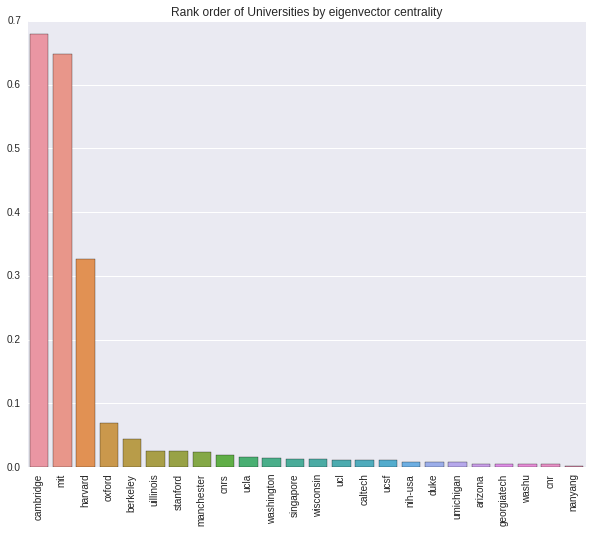

In [40]:
xu = [x[0] for x in rank_eigen]
yu = [x[1] for x in rank_eigen]

sns.barplot(x=xu, y=yu)
plt.xticks(rotation=90)
plt.title('Rank order of Universities by eigenvector centrality')
plt.show()

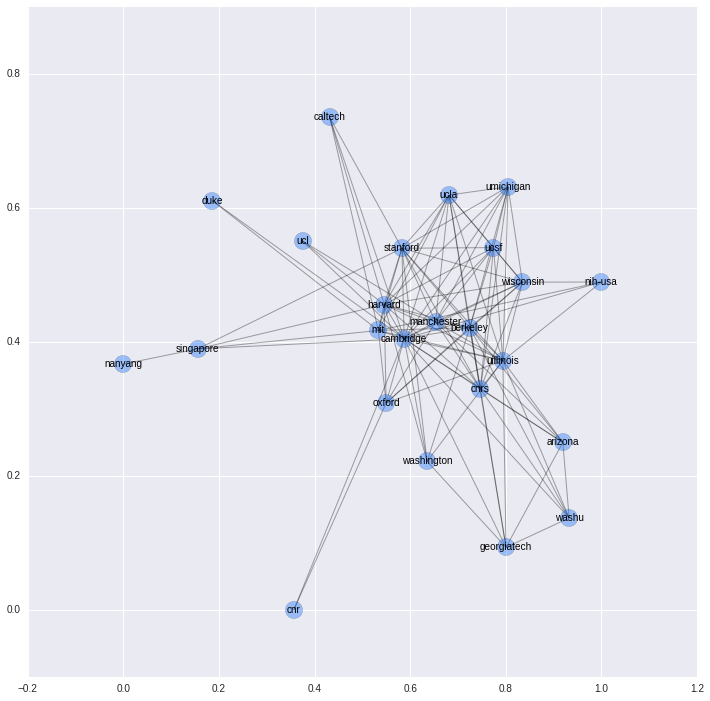

In [41]:
plt.figure(figsize=(12,12))
pos=nx.fruchterman_reingold_layout(N)
nx.draw_networkx(N, pos, nodelist=xu, node_color='#0066FF', alpha=0.35, font_size=10)

I will not repeat the plot tweaking that is presented in Lab 7.  While it does make it prettier, I am not a big fan of encoding information in the areas of the nodes.  The research that I have seens suggests that we find it difficult to make quantitative observations from area encoded graphical visualizations.

So I will close here.